Root Mean Square Error (RMSE): 1.1409989601523622
      Actual Values  Predicted Values
0         21.885714         21.861122
1         21.844118         21.864766
2         21.805556         21.862862
3         21.800000         21.858994
4         22.005714         21.857578
...             ...               ...
2288      21.997143         21.859984
2289      22.928125         21.859984
2290      22.561765         21.859984
2291      22.539474         21.859984
2292      22.458334         21.859984

[2293 rows x 2 columns]


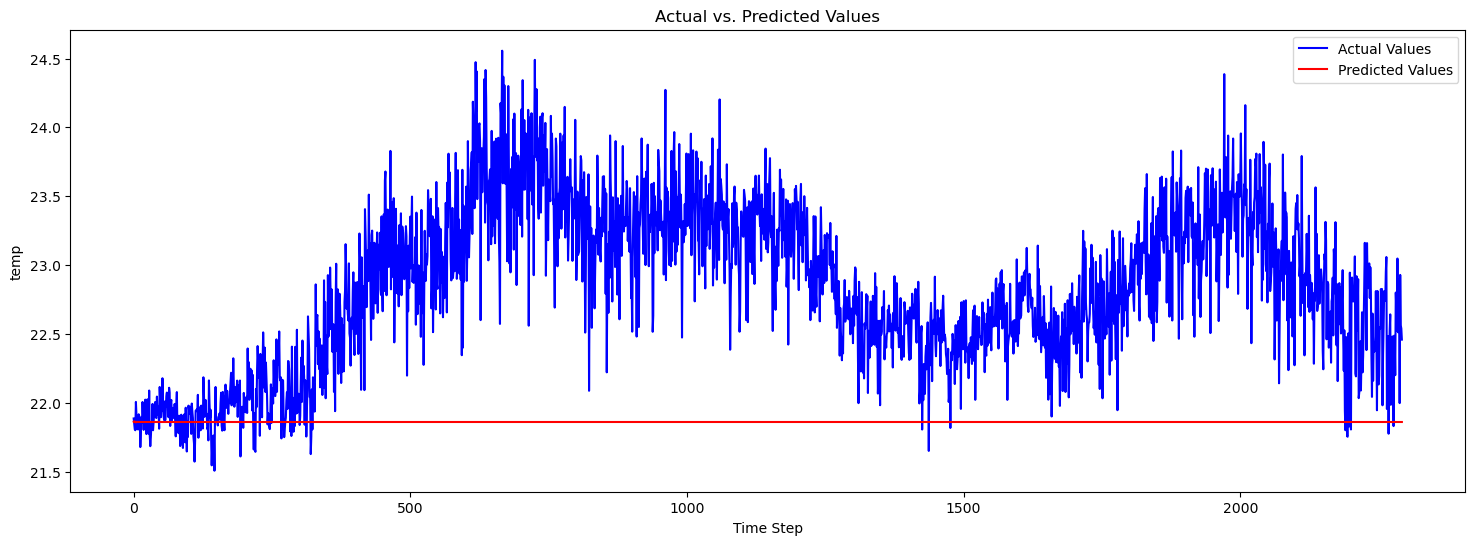

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from scipy import stats
import matplotlib.pyplot as plt
import warnings

def upload_sensor_data():
    """Download sensor data."""
    sensor_data = pd.read_csv('C:/Users/ankus/sensor.csv')
    sensor_data = sensor_data.drop(['motion'], axis=1)
    label_encoder = LabelEncoder()
    sensor_data['device'] = label_encoder.fit_transform(sensor_data['device'])
    sensor_data['light'] = label_encoder.fit_transform(sensor_data['light'])
    sensor_data['time'] = pd.to_datetime(sensor_data['ts'], unit="s")
    sensor_data = sensor_data.drop(['lpg', 'smoke', 'co', 'ts'], axis=1)
    sensor_data.set_index('time', inplace=True)
    sensor_data = sensor_data.resample('T').mean()
    sensor_data = sensor_data.reset_index()
    sensor_data
    return sensor_data

def prepare_data(sensor_data, target_column='temp', n_steps=60):
    """Prepare data for time series prediction."""
    target_values = sensor_data[target_column].values
    humidity_values = sensor_data['humidity'].values

    X, y = [], []

    for i in range(len(target_values) - n_steps):
        X.append(np.column_stack((target_values[i:i + n_steps], humidity_values[i:i + n_steps])))
        y.append(target_values[i + n_steps])

    X = np.array(X)
    y = np.array(y)

    return X, y

def remove_outliers(y_test, y_pred, threshold=3):
    """Remove outliers based on Z-score."""
    z_scores = np.abs(stats.zscore(y_test))
    y_test_no_outliers = y_test[z_scores <= threshold]
    y_pred_no_outliers = y_pred[z_scores <= threshold]
    return y_test_no_outliers, y_pred_no_outliers

def main():
    target_column = 'temp'
    n_steps = 60

    # Download sensor data
    sensor_data = upload_sensor_data()

    # Prepare data for time series prediction
    X, y = prepare_data(sensor_data, target_column, n_steps)

    # Split data using rolling window approach
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Fit ARIMA model
    order = (5, 1, 0)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        model = ARIMA(y_train, order=order)
        model_fit = model.fit()

    # Make predictions (forecast)
    y_pred = model_fit.forecast(steps=len(y_test))

    # Remove outliers
    y_test_no_outliers, y_pred_no_outliers = remove_outliers(y_test, y_pred)

    # Calculate RMSE without outliers
    rmse_no_outliers = np.sqrt(mean_squared_error(y_test_no_outliers, y_pred_no_outliers))

    print(f"Root Mean Square Error (RMSE): {rmse_no_outliers}")
    result_df = pd.DataFrame({'Actual Values': y_test_no_outliers, 'Predicted Values': y_pred_no_outliers})
    print(result_df)

    plt.figure(figsize=(18, 6))
    plt.plot(y_test_no_outliers, label='Actual Values', color='blue')
    plt.plot(y_pred_no_outliers, label='Predicted Values', color='red')
    plt.title('Actual vs. Predicted Values')
    plt.xlabel('Time Step')
    plt.ylabel(target_column)
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()
